In [1]:
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import dmidc
import pandas as pd
import dmidc.harmonie
from mllam_verification.plot import (
    plot_single_metric_gridded_map,
    plot_single_metric_timeseries,
    plot_single_metric_hovmoller,
)
from mllam_verification.operations.statistics import rmse
from datetime import datetime
from dask.distributed import Client

dmidc.__version__

'0.5.0'

In [2]:
FORECAST_DURATION = "PT18H"
FORECAST_DURATION_IN_HOURS = int(
    pd.Timedelta(FORECAST_DURATION).total_seconds() // 3600
)
RELOAD_FC = False
OUTDIR = "/dmidata/scratch/10day/maf/danra/"

In [3]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit="16GB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 59.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42583,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33309,Total threads: 2
Dashboard: http://127.0.0.1:33545/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:41845,


## Load DANRA forecast data

In [4]:
# Retrieve DANRA forecast data
if RELOAD_FC:
    ds_t2m_danra_fc = dmidc.harmonie.load(
        suite_name="DANRA",
        analysis_time=slice("2022-01-01", "2022-01-07"),
        data_kind="FORECAST",
        forecast_duration=FORECAST_DURATION,
        short_name=["t"],
        level_type="heightAboveGround",
        level=2,
        temp_filepath=OUTDIR,
    )
    ds_danra_fc = dmidc.harmonie.load(
        suite_name="DANRA",
        analysis_time=slice("2022-01-01", "2022-01-07"),
        data_kind="FORECAST",
        forecast_duration=FORECAST_DURATION,
        short_name=["u", "v"],
        level_type="isobaricInhPa",
        level=[100, 200, 250, 300, 400, 500, 600, 700, 800, 850, 900, 925, 950, 1000],
        temp_filepath=OUTDIR,
    )
else:
    fp_t2m_zarr_json = Path(
        OUTDIR,
        "analysis_time_20220101T000000+0000-20220107T000000+0000__suite_name_DANRA__data_kind_FC33hr__short_name_t__level_2__level_type_heightAboveGround__forecast_duration_18:00:00.zarr.json",
    )
    fp_uv_zarr_json = Path(
        OUTDIR,
        "analysis_time_20220101T000000+0000-20220107T000000+0000__suite_name_DANRA__data_kind_FC33hr__short_name_u-v__level_100-200-250-300-400-500-600-700-800-850-900-925-950-1000__level_type_isobaricInhPa__forecast_duration_18:00:00.zarr.json",
    )
    ds_t2m_danra_fc = xr.open_zarr(f"reference::{fp_t2m_zarr_json}", consolidated=False)
    ds_uv_danra_fc = xr.open_zarr(f"reference::{fp_uv_zarr_json}", consolidated=False)

/home/maf/ml/mllam-verification/.venv/lib/python3.12/site-packages/zarr/core/metadata/v2.py:192: UserWarning: Found an empty list of filters in the array metadata document. This is contrary to the Zarr V2 specification, and will cause an error in the future. Use None (or Null in a JSON document) instead of an empty list of filters.
  warnings.warn(msg, UserWarning, stacklevel=1)
/home/maf/ml/mllam-verification/.venv/lib/python3.12/site-packages/zarr/core/metadata/v2.py:192: UserWarning: Found an empty list of filters in the array metadata document. This is contrary to the Zarr V2 specification, and will cause an error in the future. Use None (or Null in a JSON document) instead of an empty list of filters.
  warnings.warn(msg, UserWarning, stacklevel=1)


## Load DANRA analysis data and align coordinates

In [5]:
version = "v0.5.0"
fp_root = Path(f"/dmidata/projects/cloudphysics/danra/data/{version}")

ds_danra_analysis_sl = xr.open_zarr(fp_root / "single_levels.zarr")
ds_danra_analysis_sl.attrs["suite_name"] = "danra"

ds_danra_analysis_pl = xr.open_zarr(fp_root / "pressure_levels.zarr")
ds_danra_analysis_pl.attrs["suite_name"] = "danra"

# Allign coordinates and assign datasource
ds_t2m_danra_fc = ds_t2m_danra_fc.assign_coords(
    datasource="DANRA forecast",
    x=ds_danra_analysis_sl.x,
    y=ds_danra_analysis_sl.y,
    lon=ds_danra_analysis_sl.lon,
    lat=ds_danra_analysis_sl.lat,
)
ds_uv_danra_fc = ds_uv_danra_fc.assign_coords(
    datasource="DANRA forecast",
    x=ds_danra_analysis_sl.x,
    y=ds_danra_analysis_sl.y,
    lon=ds_danra_analysis_sl.lon,
    lat=ds_danra_analysis_sl.lat,
)
# Rename and reverse
ds_uv_danra_fc = ds_uv_danra_fc.rename(level="pressure").isel(
    pressure=slice(None, None, -1)
)

# 2 meter temperature

In [6]:
# Select the relevant data
da_t2m_danra_fc: xr.DataArray = ds_t2m_danra_fc["t"]
END_TIME = da_t2m_danra_fc["time"].max().values
START_TIME = ds_t2m_danra_fc.analysis_time[0].values + np.timedelta64(3, "h")
da_t2m_danra_analysis = ds_danra_analysis_sl["t2m"].sel(
    time=slice(START_TIME, END_TIME)
)
da_t2m_danra_fc

<xarray.DataArray 't' (time: 174, analysis_time: 14, y: 589, x: 789)> Size: 9GB
dask.array<open_dataset-t, shape=(174, 14, 589, 789), dtype=float64, chunksize=(1, 1, 589, 789), chunktype=numpy.ndarray>
Coordinates:
  * time           (time) datetime64[ns] 1kB 2022-01-01T01:00:00 ... 2022-01-...
  * analysis_time  (analysis_time) datetime64[ns] 112B 2022-01-01 ... 2022-01...
    lon            (y, x) float64 4MB dask.array<chunksize=(295, 263), meta=np.ndarray>
    lat            (y, x) float64 4MB dask.array<chunksize=(295, 263), meta=np.ndarray>
  * x              (x) float64 6kB -1.999e+06 -1.997e+06 ... -2.925e+04
  * y              (y) float64 5kB -6.095e+05 -6.07e+05 ... 8.58e+05 8.605e+05
    datasource     <U14 56B 'DANRA forecast'
Attributes: (12/13)
    paramId:                    233253011
    numberOfPoints:             464721
    typeOfLevel:                heightAboveGround
    stepUnits:                  1
    stepType:                   instant
    gridType:                   lambert
    ...                         ...
    shortName:                  t
    units:                      K
    name:                       Temperature
    missingValue:               3.4028234663852886e+38
    NV:                         132
    gridDefinitionDescription:  Lambert Conformal

### RMSE between DANRA analysis and forecast

Text(0.5, 1.0, 'RMSE between DANRA forecast and analysis')

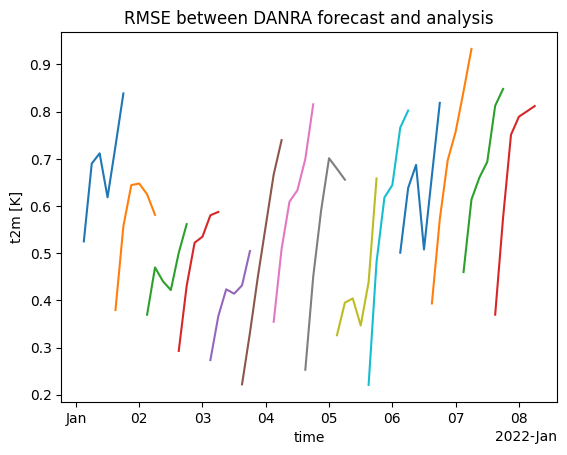

In [7]:
ax = plot_single_metric_timeseries(
    da_t2m_danra_analysis,
    da_t2m_danra_fc,
    time_axis="UTC",
    stats_operation=rmse,
    hue="analysis_time",
    xarray_plot_kwargs={"add_legend": False},
)
ax.set_title("RMSE between DANRA forecast and analysis")

### Gridded map of difference between DANRA analysis and forecast

Text(0.5, 1.0, 'Difference between DANRA forecast and analysis\n at 2022-01-01 18:00:00')

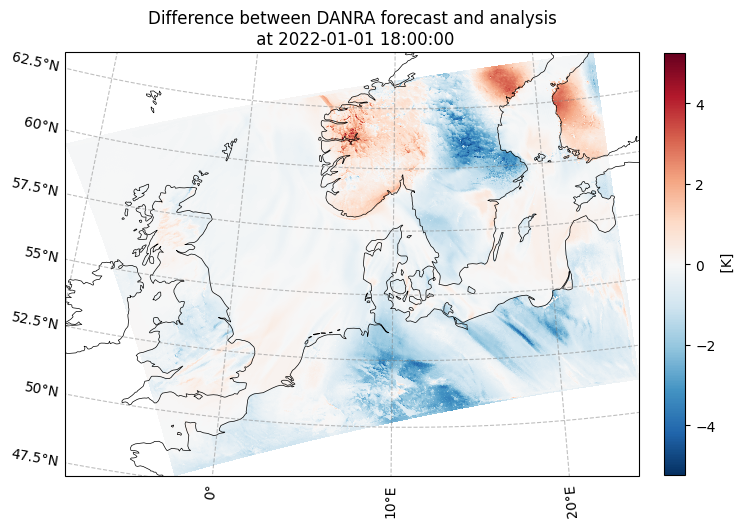

In [8]:
fig, ax = plt.subplots(
    figsize=(8, 10),
    subplot_kw={
        "projection": ccrs.AlbersEqualArea(
            central_longitude=11.0, central_latitude=55.0
        )
    },
)

# Select specific analysis time to plot
da_t2m_danra_fc_specific_anal = da_t2m_danra_fc.isel(analysis_time=0)
time_selection = datetime(2022, 1, 1, FORECAST_DURATION_IN_HOURS)

ax = plot_single_metric_gridded_map(
    da_t2m_danra_analysis,
    da_t2m_danra_fc_specific_anal,
    time_selection=time_selection,
    axes=ax,
    xarray_plot_kwargs={
        "transform": ccrs.PlateCarree(),
        "cmap": "RdBu_r",
        "cbar_kwargs": {"fraction": 0.034, "pad": 0.04},
    },
)
ax.coastlines(linewidth=0.5, color="black")
ax.gridlines(draw_labels=["bottom", "left"], color="gray", alpha=0.5, linestyle="--")
ax.set_title(
    "Difference between DANRA forecast and analysis\n at {}".format(time_selection)
)

### Hovmöller diagram of RMSE

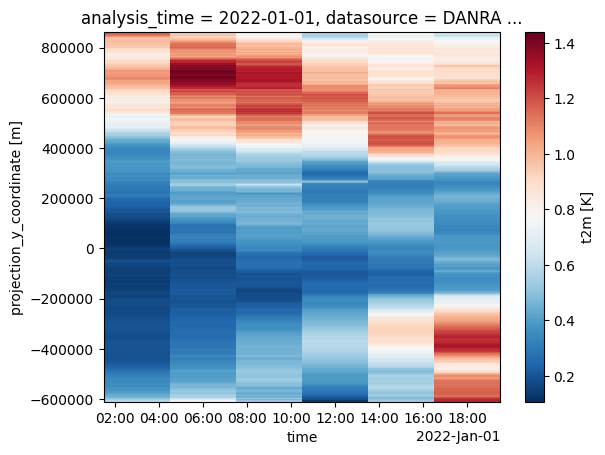

In [9]:
da_t2m_danra_fc_no_nans = da_t2m_danra_fc.isel(analysis_time=0).dropna(dim="time")
ax = plot_single_metric_hovmoller(
    da_t2m_danra_analysis,
    da_t2m_danra_fc_no_nans,
    preserve_dim="y",
    stats_operation=rmse,
    time_axis="UTC",
    xarray_plot_kwargs={"cmap": "RdBu_r"},
)

# Wind

### Prepare data

In [10]:
END_TIME = ds_uv_danra_fc["time"].max().values
START_TIME = ds_uv_danra_fc.analysis_time[0].values + np.timedelta64(3, "h")
da_u_danra_analysis = ds_danra_analysis_pl["u"].sel(
    time=slice(
        ds_uv_danra_fc.analysis_time[0].values + np.timedelta64(3, "h"), END_TIME
    ),
)
da_v_danra_analysis = ds_danra_analysis_pl["v"].sel(
    time=slice(
        ds_uv_danra_fc.analysis_time[0].values + np.timedelta64(3, "h"), END_TIME
    ),
)

# Select the relevant forecast data and adjust the coordinates
da_u_danra_fc: xr.DataArray = ds_uv_danra_fc["u"]
da_v_danra_fc: xr.DataArray = ds_uv_danra_fc["v"]
# da_u_danra_fc: xr.DataArray = ds_uv_danra_fc.sel(time=da_u_danra_analysis.time)["u"]
# da_v_danra_fc: xr.DataArray = ds_uv_danra_fc.sel(time=da_v_danra_analysis.time)["v"]
# Calculate wind speed
da_wind_speed_danra_analysis = np.sqrt(da_u_danra_analysis**2 + da_v_danra_analysis**2)
da_wind_speed_danra_fc = np.sqrt(da_u_danra_fc**2 + da_v_danra_fc**2)
da_wind_speed_danra_fc

<xarray.DataArray (time: 174, pressure: 14, analysis_time: 14, y: 589, x: 789)> Size: 127GB
dask.array<sqrt, shape=(174, 14, 14, 589, 789), dtype=float64, chunksize=(1, 1, 1, 589, 789), chunktype=numpy.ndarray>
Coordinates:
  * time           (time) datetime64[ns] 1kB 2022-01-01T01:00:00 ... 2022-01-...
  * pressure       (pressure) int64 112B 1000 950 925 900 ... 300 250 200 100
  * analysis_time  (analysis_time) datetime64[ns] 112B 2022-01-01 ... 2022-01...
    lon            (y, x) float64 4MB dask.array<chunksize=(295, 263), meta=np.ndarray>
    lat            (y, x) float64 4MB dask.array<chunksize=(295, 263), meta=np.ndarray>
  * x              (x) float64 6kB -1.999e+06 -1.997e+06 ... -2.925e+04
  * y              (y) float64 5kB -6.095e+05 -6.07e+05 ... 8.58e+05 8.605e+05
    datasource     <U14 56B 'DANRA forecast'
Attributes: (12/13)
    paramId:                    233253033
    numberOfPoints:             464721
    typeOfLevel:                isobaricInhPa
    stepUnits:                  1
    stepType:                   instant
    gridType:                   lambert
    ...                         ...
    shortName:                  u
    units:                      m s**-1
    name:                       u-component of wind
    missingValue:               3.4028234663852886e+38
    NV:                         132
    gridDefinitionDescription:  Lambert Conformal

### RMSE between DANRA analysis and forecast

Text(0, 0.5, 'Wind speed [m/s]')

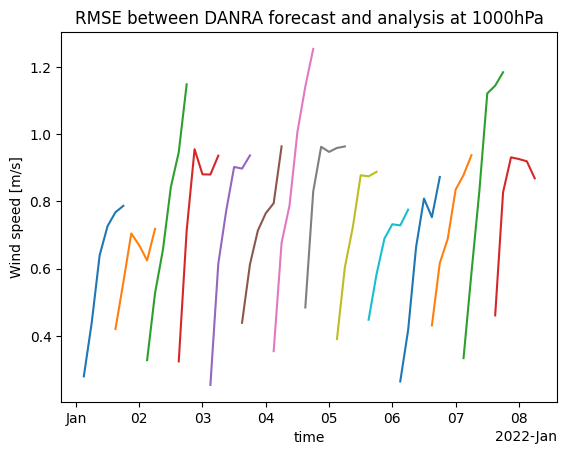

In [11]:
ax = plot_single_metric_timeseries(
    da_wind_speed_danra_analysis.sel(pressure=1000),
    da_wind_speed_danra_fc.sel(pressure=1000),
    time_axis="UTC",
    stats_operation=rmse,
    hue="analysis_time",
    xarray_plot_kwargs={"add_legend": False},
)
ax.set_title("RMSE between DANRA forecast and analysis at 1000hPa")
ax.set_ylabel("Wind speed [m/s]")

### Gridded map of difference between DANRA analysis and forecast

Text(0.5, 1.0, '1000hPa wind speed difference between DANRA forecast and analysis\n at 2022-01-01 18:00:00')

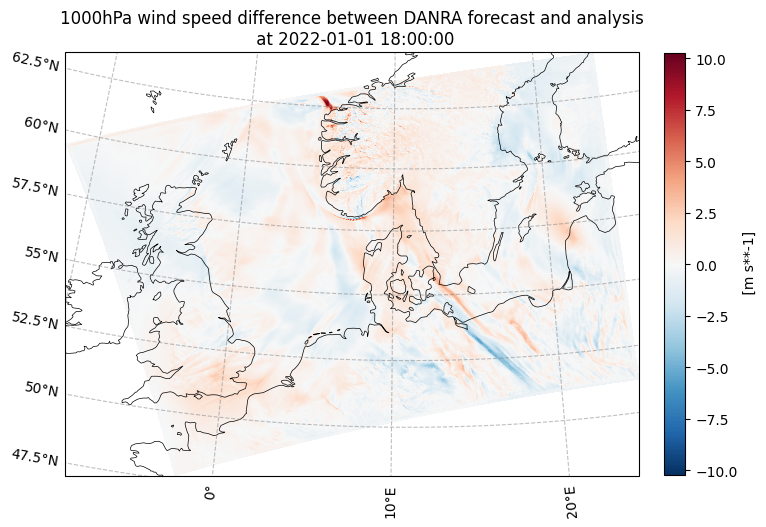

In [12]:
fig, ax = plt.subplots(
    figsize=(8, 10),
    subplot_kw={
        "projection": ccrs.AlbersEqualArea(
            central_longitude=11.0, central_latitude=55.0
        )
    },
)

# Select specific analysis time to plot
da_wind_speed_danra_fc_specific_anal = da_wind_speed_danra_fc.isel(analysis_time=0)
time_selection = datetime(2022, 1, 1, FORECAST_DURATION_IN_HOURS)

ax = plot_single_metric_gridded_map(
    da_wind_speed_danra_analysis.sel(pressure=1000),
    da_wind_speed_danra_fc_specific_anal.sel(pressure=1000),
    time_selection=time_selection,
    axes=ax,
    xarray_plot_kwargs={
        "transform": ccrs.PlateCarree(),
        "cmap": "RdBu_r",
        "cbar_kwargs": {"fraction": 0.034, "pad": 0.04},
    },
)
ax.coastlines(linewidth=0.5, color="black")
ax.gridlines(draw_labels=["bottom", "left"], color="gray", alpha=0.5, linestyle="--")
ax.set_title(
    "1000hPa wind speed difference between DANRA forecast and analysis\n at {}".format(
        time_selection
    )
)

### Hovmöller diagram of RMSE

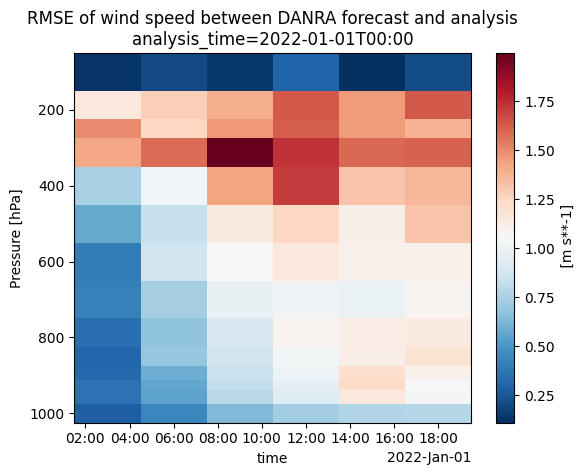

In [13]:
da_wind_speed_danra_fc_no_nans = da_wind_speed_danra_fc.isel(analysis_time=0).dropna(
    dim="time"
)
ax = plot_single_metric_hovmoller(
    da_wind_speed_danra_analysis,
    da_wind_speed_danra_fc_no_nans,
    preserve_dim="pressure",
    time_axis="UTC",
    stats_operation=rmse,
    xarray_plot_kwargs={"cmap": "RdBu_r"},
)
ax.set_title(
    "RMSE of wind speed between DANRA forecast and analysis\nanalysis_time={}".format(
        np.datetime_as_string(
            da_wind_speed_danra_fc_no_nans.analysis_time.values, unit="m"
        )
    )
)
ax.set_ylabel("Pressure [hPa]")
ax.invert_yaxis()